<code> 
<strong><font size="+3">COLLECTING ALL BLOB-LIKE EVENTS</font></strong>
In this Jupyter notebook, we collect all blob-like events from all ensemble members.
</code>

<code> Import packages </code>

In [1]:
import xarray as xr; import numpy as np; import pandas as pd
import netCDF4 as nc; import scipy
import matplotlib.pyplot as plt

from sklearn import preprocessing # will use MinMaxScaler from sklearn

<code> Area of interest </code>

In [2]:
# latitude and longitude range for the North Pacific Ocean
lon_lim_less = 0.; lon_lim_great = 67.5 # x
lat_lim_less = 20.; lat_lim_great = 60. # y

# rescale
x_list = np.array([-180, lon_lim_less, lon_lim_great, 180]).reshape(-1,1)
x_scaler = preprocessing.MinMaxScaler(feature_range=(0, 287))
x_normalizedlist=x_scaler.fit_transform(x_list)

y_list = np.array([-90, lat_lim_less, lat_lim_great, 90]).reshape(-1,1)
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 191))
y_normalizedlist=y_scaler.fit_transform(y_list)

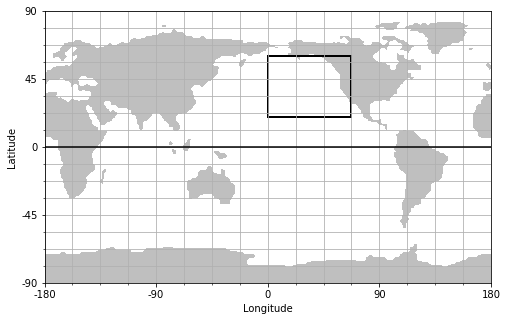

In [3]:
from matplotlib import patches # for the purpose of plotting

NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 

# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
ax.add_patch(NPO_patch)
plt.show()

<code> Collecting all blob-like events </code>

In [4]:
filename = '/glade/work/cassiacai/member0_events.nc'
member_ = xr.open_dataset(filename)

# How many heatwaves are in this particular ensemble member?
ending_val = len(np.unique(member_.labels))
print(ending_val)

371


In [5]:
full_use_grids = []
#; full_SST_grids = []

for i in range(1,ending_val):
    mhw_id = i
    mhw_event_rel = member_.where(member_.labels==mhw_id, drop=False)   # dimensions are (481, 192, 288) --> (time, lat, lon)
    x = mhw_event_rel.SSTA[:,:,:]
    # full_SST_grids.append(x)
    no_nans_x = np.nan_to_num(x) # replace all nans with zeroes
    no_nans_x[no_nans_x != 0] = 1 # replace all SSTA values with 1 (for shape comparison)
    full_use_grids.append(no_nans_x)

In [7]:
full__analysis_arrays = [] # all MHWs
density_analysis_arrays = [] # MHWs that last longer than X months
short_density_analysis_arrays = [] # MHWs that are X months long
i_index = []

grids_to_use = full_use_grids

for i in range(0,len(grids_to_use)):
    sum_of_one = grids_to_use[i].sum(axis=(0))
    reshaped_sum_of_one = grids_to_use[i].reshape(481,192*288)
    a = reshaped_sum_of_one.sum(axis=(1))

    # nonzeroind = np.nonzero(a) # starts at 1975-01-01 and ends on 2015-01-01
    event_len = np.nanmax(sum_of_one)

    if event_len > 1: # Can change this so we are looking at really long heatwaves
        density_analysis_arrays.append(sum_of_one)
        full__analysis_arrays.append(sum_of_one)
        i_index.append(i)
    else:
        short_density_analysis_arrays.append(sum_of_one)
        full__analysis_arrays.append(sum_of_one)

<code> Collect events with a footprint in our area of interest </code>

In [8]:
f_row = int(np.round(y_normalizedlist[1].item()))
l_row = int(np.round(y_normalizedlist[2].item()))

f_col = int(np.round(x_normalizedlist[1].item()))
l_col = int(np.round(x_normalizedlist[2].item()))

In [9]:
# let us keep all events that lasts more than 2 months
indices = []; len_of_longerthan1month_indices = []
for i in range(ending_val-1):
    if np.sum(full__analysis_arrays[i][f_row:l_row,f_col:l_col]) > 0 and np.nanmax(full__analysis_arrays[i]) > 2: 
        indices.append(i)
        len_of_longerthan1month_indices.append(np.nanmax(full__analysis_arrays[i]))

In [10]:
len(len_of_longerthan1month_indices)

34

In [11]:
# let us keep all events where at least 25% of our region of interest is a heatwave
kept_indices = []
for i in range(len(indices)):
    array_of_interest = np.copy(full__analysis_arrays[indices[i]][f_row:l_row,f_col:l_col])
    array_of_interest[array_of_interest != 0] = 1
    if np.nansum(array_of_interest) / (42*53*0.01) >= 25: 
        kept_indices.append(indices[i])

In [12]:
print(len(kept_indices))

13


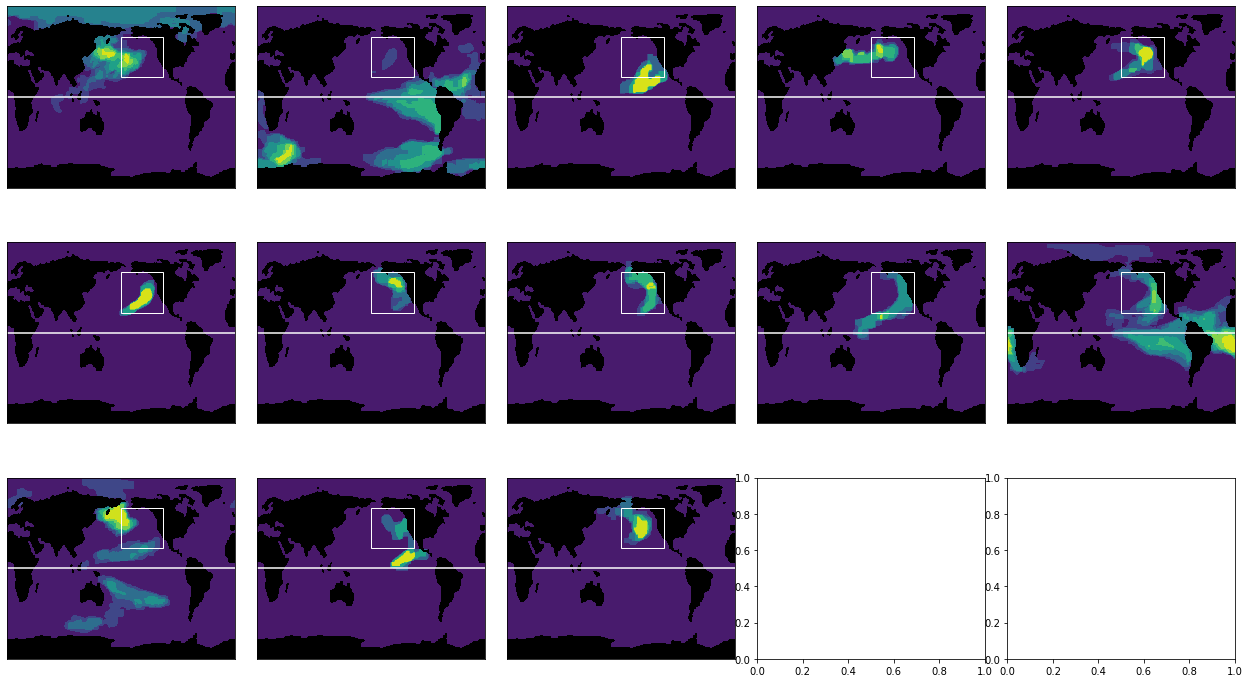

In [13]:
fig, axs = plt.subplots(3,5, figsize=(22, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.1)
axs = axs.ravel()

for i in range(len(kept_indices)):
    NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=1, edgecolor='white', facecolor='none',alpha=1) 

    axs[i].contourf(full__analysis_arrays[kept_indices[i]])
    axs[i].contourf(land_mask,cmap='binary_r',vmin=0)
    axs[i].minorticks_on()
    axs[i].axhline(y=95.5, c='white', linestyle='-') # this is the equator line
    axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axs[i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    axs[i].add_patch(NPO_patch)

In [14]:
kept_indices

[1, 18, 85, 130, 149, 151, 180, 200, 206, 268, 278, 308, 358]

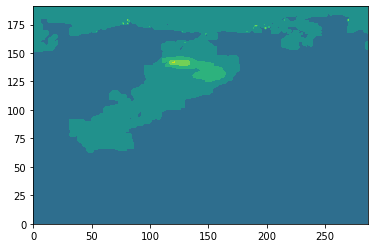

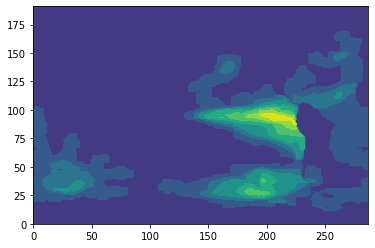

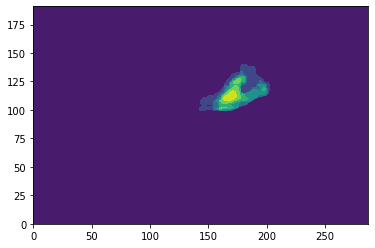

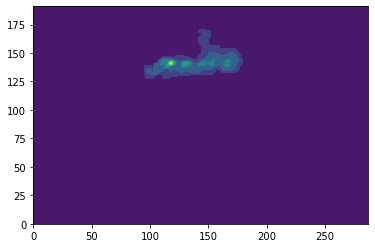

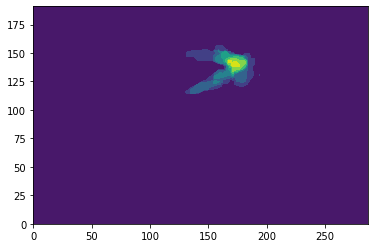

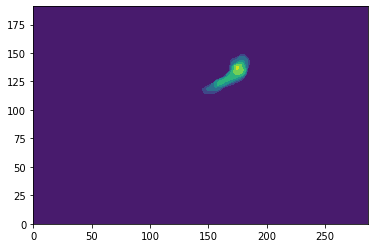

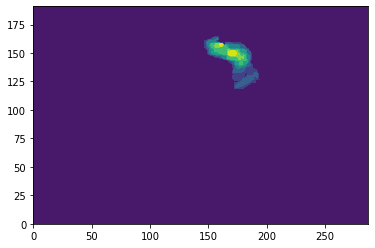

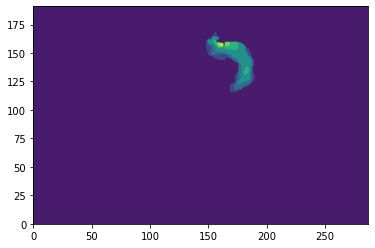

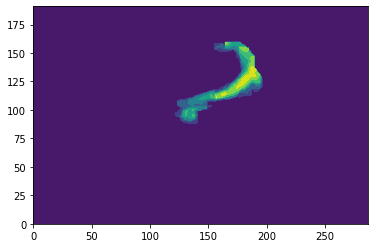

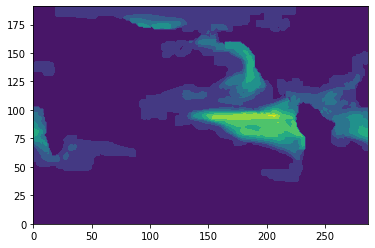

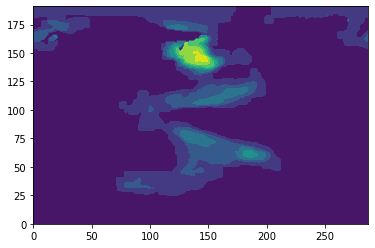

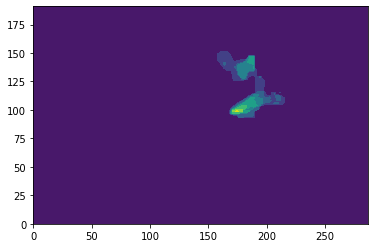

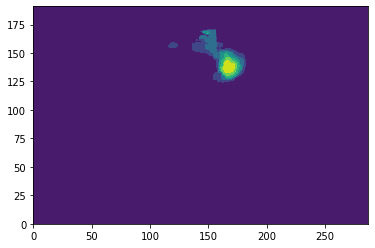

In [23]:
kept_heatwaves = []
for i in range(len(kept_indices)):
    mhw_event_sel = member_.where(member_.labels==kept_indices[i]+1, drop=False)
    plt.contourf(mhw_event_sel.SSTA.sum(axis=(0)))
    plt.show()
    kept_heatwaves.append(mhw_event_sel)

In [16]:
concated_kept_heatwaves_xarray = xr.concat(kept_heatwaves, "heatwave_label")

In [17]:
concated_kept_heatwaves_xarray

<xarray.Dataset>
Dimensions:    (heatwave_label: 13, time: 481, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 1975-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member_id  <U11 'r1i1001p1f1'
    quantile   float64 0.9
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: heatwave_label
Data variables:
    labels     (heatwave_label, time, lat, lon) float64 nan nan nan ... nan nan
    SSTA       (heatwave_label, time, lat, lon) float64 nan nan nan ... nan nan

In [ ]:
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member'+str(i)+'_bloblike_events.nc')